# Use this notebook to try new models and augmentations and validate their performance

# Imports

In [32]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
import gc

#import wandb
#from fastai.callback.wandb import *

#wandb.init(project="cassava", entity="teo03")

# Setup

In [33]:
path_str = '../data'
PATH = Path(path_str)

images_path = Path(path_str + '/train_images')
csv_path = Path(path_str + '/train.csv')

full_df = pd.read_csv(csv_path)

# Create a smaller dataset

In [34]:
#msk = np.random.rand(len(full_df)) < 0.1

#full_df = full_df[msk]
#len(small_df)

# Split to train/test sets

In [35]:
train_df, test_df = train_test_split(full_df, test_size=0.1)

In [36]:
len(train_df), len(test_df)

(19257, 2140)

# Data and helper functions

In [39]:
def generate_block(val_index=None):
    
    def get_x(row): return images_path/row['image_id']
    def get_y(row): return row['label']
    
    
    # TRAIN BLOCK
    if val_index is not None:
        return DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=get_x,
            get_y=get_y,
            splitter=IndexSplitter(val_index),
            item_tfms=[
                Resize(384),
                FlipItem(p=0.4),
                RandomCrop(300)
            ],
            batch_tfms=[RandomResizedCropGPU(280), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
        )
    
    
    # TEST BLOCK
    else:
        return DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_x=get_x,
            get_y=get_y,
            item_tfms=[
                Resize(384)
            ],
            batch_tfms=[RandomResizedCropGPU(280), *aug_transforms(), Normalize.from_stats(*imagenet_stats)]
        )
    

In [38]:
def train(dl, arch, epochs=25, freeze_epochs=10):
    learn = cnn_learner(
        dl,
        arch,
        metrics=accuracy,
        loss_func=LabelSmoothingCrossEntropy(),
        opt_func=ranger,
        cbs=[
            #WandbCallback(log_preds=False, log_model=False, n_preds=10),
            SaveModelCallback(fname=str(arch.__name__)),
        ],
    ).to_fp16()
    
    lr_min, lr_steep = learn.lr_find()
    print('found lr of: ' + str(lr_min))
    
    learn.fine_tune(epochs, base_lr=round(lr_min, 5), freeze_epochs=freeze_epochs)
    
    return learn

In [40]:
#train_block = generate_block(12)
#train_dl = train_block.dataloaders(train_df, bs=8)

#train_dl.show_batch()

# Validation

In [ ]:
folds = 2
skf = StratifiedKFold(n_splits=folds, shuffle=True)

starting validation on 2 folds


found lr of: 0.0007585775572806596


epoch,train_loss,valid_loss,accuracy,time
0,1.513994,1.117912,0.668813,03:33


Better model found at epoch 0 with valid_loss value: 1.1179120540618896.


epoch,train_loss,valid_loss,accuracy,time
0,1.281206,0.992215,0.711600,04:28


Better model found at epoch 0 with valid_loss value: 0.9922152161598206.


Better model found at epoch 0 with valid_loss value: 0.7116003632545471.


Better model found at epoch 0 with valid_loss value: 0.7143691778182983.
done, appending results..
starting validation on 2 folds


found lr of: 0.006918309628963471


epoch,train_loss,valid_loss,accuracy,time
0,1.349707,1.120273,0.663897,03:37


Better model found at epoch 0 with valid_loss value: 1.1202726364135742.


epoch,train_loss,valid_loss,accuracy,time
0,0.971666,0.854612,0.782198,04:16


Better model found at epoch 0 with valid_loss value: 0.8546119928359985.


Better model found at epoch 0 with valid_loss value: 0.7821977734565735.


Better model found at epoch 0 with valid_loss value: 0.773948609828949.
done, appending results..


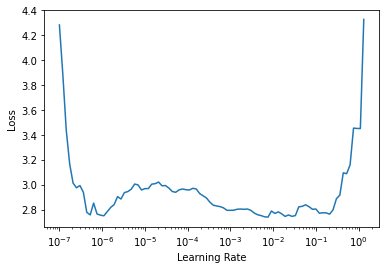

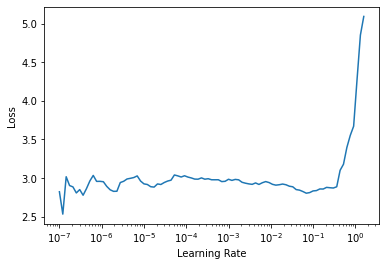

In [41]:
val_pct = []
test_pct = []

for train_index, val_index in skf.split(train_df.index, train_df['label']):
    print('starting validation on ' + str(folds) + ' folds \n' )
    
    batch_size = 8
    
    train_block = generate_block(val_index)
    train_dl = train_block.dataloaders(train_df, bs=batch_size)
    
    test_block = generate_block()
    test_dl = test_block.dataloaders(test_df, bs=batch_size)
    
    
    test_dl.valid = test_dl.train
    
    learn = train(train_dl, resnet18, 1, 1)
    _, val = learn.validate()
    
    learn.dls.valid = test_dl.valid
    _, test = learn.validate()
  

    print('done, appending results.. \n')

    val_pct.append(val)
    test_pct.append(test)

In [42]:
print(f'Validation\nmean: {np.mean(val_pct)}\nstd: {np.std(val_pct)}')

Validation
mean: 0.7468990683555603
std: 0.035298705101013184


In [43]:
print(f'Test\nmean: {np.mean(test_pct)}\nstd: {np.std(test_pct)}')

Test
mean: 0.7441588938236237
std: 0.029789716005325317


If the model is good use that architecture and parameters to train on more epochs